In [1]:
import re
import requests

def extract_ips_from_log(log_file_path):
    unique_ips = set()
    with open(log_file_path, 'r') as file:
        for line in file:
            # Extract IP addresses using regular expression
            ips = re.findall(r'\d+\.\d+\.\d+\.\d+', line)
            # Add unique IP addresses to the set
            unique_ips.update(ips)
    return list(unique_ips)

log_file_path = 'access.log'  # Replace with your log file path
unique_ips = extract_ips_from_log(log_file_path)

print("Unique IP addresses:")
print(unique_ips)

Unique IP addresses:
['121.99.121.185', '46.119.114.245', '216.152.243.146', '195.56.119.209', '129.10.115.241', '79.101.87.86', '81.142.35.154', '94.197.120.210', '94.153.8.37', '219.89.193.142', '180.76.6.53', '187.210.142.8', '74.125.40.22', '117.244.105.81', '5.10.83.66', '193.58.82.178', '157.56.92.164', '74.125.40.19', '212.107.116.234', '217.172.190.158', '69.63.23.193', '125.239.81.249', '34.0.1833.5', '95.153.110.172', '155.140.133.248', '134.192.71.41', '3.2.0.12012', '94.7.95.97', '180.180.100.65', '81.154.31.181', '184.153.164.52', '54.242.155.74', '173.242.120.61', '208.43.251.181', '26.0.1410.43', '223.67.143.84', '178.19.99.105', '91.179.36.136', '184.154.100.130', '157.56.229.184', '70.112.152.59', '89.176.234.221', '199.74.99.157', '155.63.71.11', '80.252.78.170', '204.15.164.228', '108.91.82.251', '50.157.244.41', '32.0.1700.103', '74.125.176.147', '128.237.28.16', '122.56.232.122', '69.50.176.67', '81.56.9.191', '203.219.2.2', '1.9.0.7', '54.242.254.219', '68.13.110.

In [2]:
ip_location_dict = {}

In [17]:
for ip in unique_ips:
    try:
        response = requests.get(f'https://api.ipbase.com/v1/json/{ip}')
        location_data = response.json()
        location = location_data.get('country_name', 'Unknown')
        ip_location_dict[ip] = location
        unique_ips.remove(ip)
        if len(unique_ips) == 0:
            print("All locations extracted")
            break
    except Exception as e:
        try:
            response = requests.get(f'https://freeipapi.com/api/json/{ip}')
            location_data = response.json()
            location = location_data.get('countryName', 'Unknown')
            ip_location_dict[ip] = location
            unique_ips.remove(ip)
            if len(unique_ips) == 0:
                print("All locations extracted")
                break 
        except Exception as e:
            print('Unknown')
            break

All locations extracted


In [18]:
print(len(ip_location_dict))

1863


In [19]:
import pandas as pd
from datetime import datetime
from user_agents import parse

def extract_log_info(log_line, ip_location_dict):
    regex = r'(\d+\.\d+\.\d+\.\d+) - - \[(.*?)\] "(.*?)" (\d+) (\d+) "(.*?)" "(.*?)"'
    matches = re.match(regex, log_line)
    if matches:
        ip = matches.group(1)
        date_time_str = matches.group(2)
        date_time = datetime.strptime(date_time_str, '%d/%b/%Y:%H:%M:%S %z')
        date = date_time.date()
        time = date_time.time()
        request_info = matches.group(3).split()
        request_method = request_info[0]
        url = request_info[1]
        status_code = int(matches.group(4))
        size = int(matches.group(5))
        referer = matches.group(6)
        user_agent_str = matches.group(7)
        
        user_agent = parse(user_agent_str)
        os = user_agent.os.family
        
        if ip in ip_location_dict:
            location = ip_location_dict[ip]
        else:
            location = 'Unknown'

        bot = get_search_bot(user_agent_str)
        
        return [ip, location, str(date), str(time), request_method, url, status_code, size, user_agent_str, os, bot]
    else:
        return None

def get_search_bot(user_agent):
    bot_patterns = [
        (r'Googlebot', 'Google'),
        (r'Bingbot', 'Bing'),
        (r'Yahoo! Slurp', 'Yahoo'),
        (r'Baiduspider', 'Baidu')
    ]
    
    for pattern, bot_name in bot_patterns:
        if re.search(pattern, user_agent):
            return bot_name
    return None

log_file_path = 'access.log'
log_info_list = []
counter = 1
with open(log_file_path, 'r') as file:
    for line in file:
        log_info = extract_log_info(line, ip_location_dict)
        if log_info:
            log_info_list.append(log_info)
        if counter % 1000 == 0:
            print(f"Number of records {counter}")
        counter+=1

df = pd.DataFrame(log_info_list, columns=['IP', 'IP Location', 'Date', 'Time', 'Request Method', 'URL', 'Status Code', 'Size', 'User Agent', 'Operating System', 'Search Bot'])

Number of records 1000
Number of records 2000
Number of records 3000
Number of records 4000
Number of records 5000
Number of records 6000
Number of records 7000
Number of records 8000
Number of records 9000
Number of records 10000


In [20]:
df.head(10)

,IP,IP Location,Date,Time,Request Method,URL,Status Code,Size,User Agent,Operating System,Search Bot
0,83.149.9.216,Russian Federation,2015-05-17,10:05:03,GET,/presentations/logstash-monitorama-2013/images...,200,203023,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
1,83.149.9.216,Russian Federation,2015-05-17,10:05:43,GET,/presentations/logstash-monitorama-2013/images...,200,171717,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
2,83.149.9.216,Russian Federation,2015-05-17,10:05:47,GET,/presentations/logstash-monitorama-2013/plugin...,200,26185,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
3,83.149.9.216,Russian Federation,2015-05-17,10:05:12,GET,/presentations/logstash-monitorama-2013/plugin...,200,7697,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
4,83.149.9.216,Russian Federation,2015-05-17,10:05:07,GET,/presentations/logstash-monitorama-2013/plugin...,200,2892,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
5,83.149.9.216,Russian Federation,2015-05-17,10:05:34,GET,/presentations/logstash-monitorama-2013/images...,200,430406,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
6,83.149.9.216,Russian Federation,2015-05-17,10:05:57,GET,/presentations/logstash-monitorama-2013/css/fo...,200,38720,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
7,83.149.9.216,Russian Federation,2015-05-17,10:05:50,GET,/presentations/logstash-monitorama-2013/css/fo...,200,41820,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
8,83.149.9.216,Russian Federation,2015-05-17,10:05:24,GET,/presentations/logstash-monitorama-2013/images...,200,52878,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None
9,83.149.9.216,Russian Federation,2015-05-17,10:05:50,GET,/presentations/logstash-monitorama-2013/images...,200,321631,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,Mac OS X,None


In [21]:
df.to_csv('access_logs.csv', index=False)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9330 entries, 0 to 9329
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   IP                9330 non-null   object
 1   IP Location       9330 non-null   object
 2   Date              9330 non-null   object
 3   Time              9330 non-null   object
 4   Request Method    9330 non-null   object
 5   URL               9330 non-null   object
 6   Status Code       9330 non-null   int64 
 7   Size              9330 non-null   int64 
 8   User Agent        9330 non-null   object
 9   Operating System  9330 non-null   object
 10  Search Bot        653 non-null    object
dtypes: int64(2), object(9)
memory usage: 801.9+ KB


In [28]:
user_count_per_day = df.groupby('Date')['IP'].nunique()
user_count_per_day.to_csv('./results/user_count_per_day.csv', index=True)

In [23]:
print(user_count_per_day)

Date
2015-05-17    325
2015-05-18    584
2015-05-19    526
2015-05-20    478
Name: IP, dtype: int64


In [29]:
user_rank_by_user_agent = df.groupby('User Agent')['IP'].nunique().sort_values(ascending=False)
user_rank_by_user_agent.to_csv('./results/user_rank_by_user_agent.csv', index=True)

In [30]:
user_rank_by_user_agent.head(10)

User Agent
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36               103
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:22.0) Gecko/20100101 Firefox/22.0                                            80
Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html)                                          73
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:21.0) Gecko/20100101 Firefox/21.0                                            65
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:27.0) Gecko/20100101 Firefox/27.0                                                     59
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36                    50
-                                                                                                                            47
Mozilla/5.0 (X11; Linux x86_64; rv:27.0) Gecko/20100101 Firefox/27.0                         

In [33]:
user_rank_by_os = df.groupby('Operating System')['IP'].nunique().sort_values(ascending=False).reset_index()
user_rank_by_os.to_csv('./results/user_rank_by_os.csv', index=True)

In [34]:
print(user_rank_by_os)

   Operating System   IP
0           Windows  559
1             Other  336
2          Mac OS X  303
3             Linux  252
4            Ubuntu  106
5           Android   83
6               iOS   55
7         Chrome OS    2
8            NetBSD    2
9            CentOS    1
10          FreeBSD    1
11          OpenBSD    1
12          Solaris    1
13   Windows Mobile    1
14    Windows Phone    1


In [40]:
user_rank_by_country = df.groupby('IP Location')['IP'].nunique().sort_values(ascending=False).reset_index()
user_rank_by_country.to_csv('./results/user_rank_by_country.csv', index=False)

In [41]:
print(user_rank_by_country)

                                           IP Location   IP
0                             United States of America  546
1                                                China  135
2                                              Germany   99
3                                               France   81
4    United Kingdom of Great Britain and Northern I...   64
..                                                 ...  ...
96                                              Kuwait    1
97                                               Libya    1
98                                          Luxembourg    1
99                                               Malta    1
100                   Tanzania, the United Republic of    1

[101 rows x 2 columns]


In [44]:
search_bots_sorted = df['Search Bot'].value_counts().reset_index()
search_bots_sorted.columns = ['Search Bot', 'Count']
search_bots_sorted = search_bots_sorted.sort_values(by='Count', ascending=False)
search_bots_sorted.to_csv('./results/search_bots_sorted.csv', index=False)

print("Sorted Search Bots:")
print(search_bots_sorted)

Sorted Search Bots:
  Search Bot  Count
0     Google    470
1      Yahoo    100
2      Baidu     83


In [109]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('access_logs.csv')

df['Date'] = pd.to_datetime(df['Date'])

df['Status Code group'] = df['Status Code'].apply(lambda x: 'Success' if str(x).startswith(('2', '3')) else 'Status Code error')

df['Time'] = pd.to_datetime(df['Time'])
df['Day'] = df['Time'].apply(lambda x: 'day' if 6 <= x.hour < 12 else 'night')

grouped_data = df.groupby(['IP', 'Status Code group', 'Date', 'Day']).size().unstack(fill_value=0).reset_index()

grouped_data.columns.name = None
grouped_data.rename(columns={'day': 'Day_count', 'night': 'Night_count'}, inplace=True)
grouped_data['Total_count'] = grouped_data['Day_count'] + grouped_data['Night_count']

grouped_data.head()


,IP,Status Code group,Date,Day_count,Night_count,Total_count
0,1.22.35.226,Success,2015-05-19,6,0,6
1,100.2.4.116,Success,2015-05-18,0,4,4
2,100.2.4.116,Success,2015-05-19,0,2,2
3,100.43.83.137,Success,2015-05-17,0,13,13
4,100.43.83.137,Success,2015-05-18,16,2,18


In [110]:
grouped_df = grouped_data.groupby(['IP', 'Date']).agg({
    'Status Code group': lambda x: (x == 'Status Code error').sum(),  # Error count
    'Day_count': 'sum',
    'Night_count': 'sum',
    'Total_count': 'sum'
}).reset_index()

# Step 2: Calculate additional metrics
grouped_df['Success_count'] = grouped_df['Total_count'] - grouped_df['Status Code group']
grouped_df['Success_rate'] = grouped_df['Success_count'] / grouped_df['Total_count']
grouped_df['Error_rate'] = grouped_df['Status Code group'] / grouped_df['Total_count']
grouped_df['Day_rate'] = grouped_df['Day_count'] / (grouped_df['Day_count'] + grouped_df['Night_count'])
grouped_df['Night_rate'] = grouped_df['Night_count'] / (grouped_df['Day_count'] + grouped_df['Night_count'])

# Step 3: Select the required columns
new_df = grouped_df[['IP', 'Date', 'Day_count', 'Night_count', 'Status Code group', 
                     'Success_count', 'Total_count', 'Success_rate', 'Error_rate','Day_rate', 'Night_rate']]
new_df.rename(columns={'Status Code group': 'Status_Code_Error'}, inplace=True)

new_df.head(10)

,IP,Date,Day_count,Night_count,Status_Code_Error,Success_count,Total_count,Success_rate,Error_rate,Day_rate,Night_rate
0,1.22.35.226,2015-05-19,6,0,0,6,6,1.000000,0.000000,1.000000,0.000000
1,100.2.4.116,2015-05-18,0,4,0,4,4,1.000000,0.000000,0.000000,1.000000
2,100.2.4.116,2015-05-19,0,2,0,2,2,1.000000,0.000000,0.000000,1.000000
3,100.43.83.137,2015-05-17,0,13,0,13,13,1.000000,0.000000,0.000000,1.000000
4,100.43.83.137,2015-05-18,16,2,0,18,18,1.000000,0.000000,0.888889,0.111111
5,100.43.83.137,2015-05-19,1,17,0,18,18,1.000000,0.000000,0.055556,0.944444
6,100.43.83.137,2015-05-20,0,4,0,4,4,1.000000,0.000000,0.000000,1.000000
7,101.119.18.35,2015-05-19,0,33,1,32,33,0.969697,0.030303,0.000000,1.000000
8,101.199.108.50,2015-05-19,0,3,0,3,3,1.000000,0.000000,0.000000,1.000000
9,101.226.168.196,2015-05-18,1,0,0,1,1,1.000000,0.000000,1.000000,0.000000


In [111]:
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler

df = new_df.copy()
df_numeric = df.drop(columns=['IP']).apply(pd.to_numeric)

z_score_scaler = StandardScaler()
df_scale = pd.DataFrame(z_score_scaler.fit_transform(df_numeric), columns=df_numeric.columns)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)

tsne_result = tsne.fit_transform(df_scale)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1913 samples in 0.004s...
[t-SNE] Computed neighbors for 1913 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1913
[t-SNE] Computed conditional probabilities for sample 1913 / 1913
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.608742
[t-SNE] KL divergence after 300 iterations: 0.368360


In [112]:
tsne_result

array([[  4.7173543,   6.981183 ],
       [ -0.5646736,  -3.6786597],
       [  2.8956687, -10.933567 ],
       ...,
       [  4.761132 ,  -2.74885  ],
       [ -4.2046685,   3.5408869],
       [ 11.80616  ,  -1.0378376]], dtype=float32)

In [113]:
df_scale['tsne-2d-one'] = tsne_result[:,0]
df_scale['tsne-2d-two'] = tsne_result[:,1]

In [114]:
df_scale.head()

,Date,Day_count,Night_count,Status_Code_Error,Success_count,Total_count,Success_rate,Error_rate,Day_rate,Night_rate,tsne-2d-one,tsne-2d-two
0,0.380531,1.300384,-0.438919,-0.234856,0.114988,0.109284,0.168199,-0.168199,1.959877,-1.959877,4.717354,6.981183
1,-0.582373,-0.287468,0.024210,-0.234856,-0.080717,-0.085371,0.168199,-0.168199,-0.545506,0.545506,-0.564674,-3.678660
2,0.380531,-0.287468,-0.207355,-0.234856,-0.276422,-0.280026,0.168199,-0.168199,-0.545506,0.545506,2.895669,-10.933567
3,-1.545277,-0.287468,1.066250,-0.234856,0.799957,0.790576,0.168199,-0.168199,-0.545506,0.545506,4.596461,-1.281880
4,-0.582373,3.946804,-0.207355,-0.234856,1.289220,1.277213,0.168199,-0.168199,1.681501,-1.681501,4.561823,4.808661


In [124]:
from sklearn.ensemble import IsolationForest
import seaborn as sns

In [125]:
outlier_frac = 0.028

In [126]:
iso_model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=outlier_frac)

In [127]:
iso_model.fit(df_scale)

IsolationForest(contamination=0.028, max_features=3, n_estimators=200,
                n_jobs=-1, random_state=42)

In [128]:
new_df['anomaly_isolated'] = pd.Series(iso_model.predict(df_scale))

In [129]:
new_df['anomaly_isolated'] = new_df['anomaly_isolated'].map( {1: 0, -1: 1} )

In [130]:
new_df['anomaly_isolated'].value_counts()

anomaly_isolated
0    1859
1      54
Name: count, dtype: int64

In [133]:
new_df['tsne-2d-one'] = df_scale['tsne-2d-one']
new_df['tsne-2d-two'] = df_scale['tsne-2d-two']

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

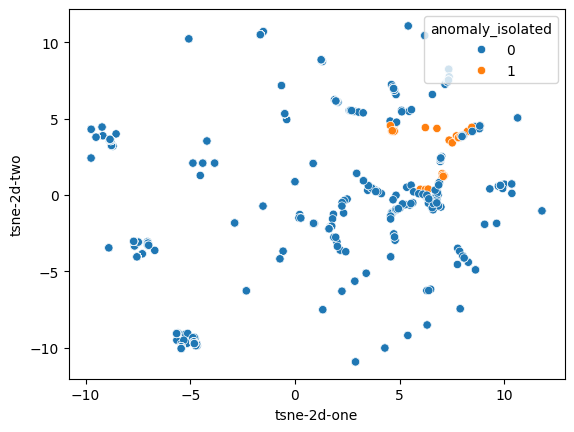

In [134]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    data=new_df,
    legend="full",
    alpha=1
)